In [4]:
# import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

### Utility functions to generate data and plot

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

### Generate data

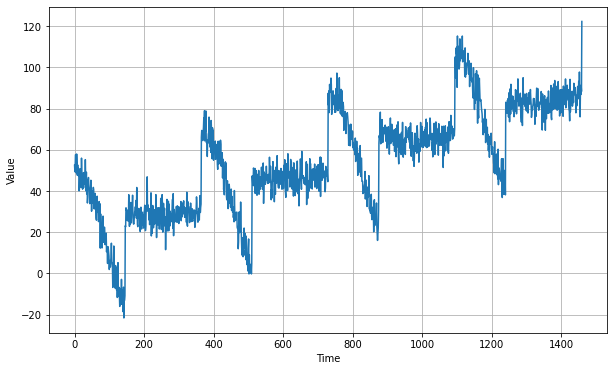

In [6]:
# generate data

# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

### Split data

In [7]:
split_time = 1000

train_series = series[:split_time]
train_time = time[:split_time]

valid_series = series[split_time:]
valid_time = time[split_time:]

print(train_series.shape)
print(valid_series.shape)

(1000,)
(461,)


### Prepare datasets

In [11]:
def generate_windowed_datasets(series, batch_size, buffer_size, window_size):
    
    # generate data
    datasets = tf.data.Dataset.from_tensor_slices(series)
    
    # windowing
    datasets = datasets.window(size=window_size + 1, shift=1, drop_remainder=True)
    
    # flattenning
    datasets = datasets.flat_map(lambda window: window.batch(window_size + 1))
    
    # create features and labels
    datasets = datasets.map(lambda window: (window[:-1], window[-1]))
    
    # shuffle the data
    datasets = datasets.shuffle(buffer_size=buffer_size)
    
    # batching
    datasets = datasets.batch(batch_size=batch_size).prefetch(1)
    
    return datasets

In [12]:
# define parameters

window_size = 30
batch_size = 32
buffer_size = 1000

In [13]:
# generate data

train_datasets = generate_windowed_datasets(train_series, batch_size, buffer_size, window_size)

for data in train_datasets.take(1):
    print('Shape feature: {}'.format(data[0].shape))
    print('Label feature: {}'.format(data[1].shape))
    print('Type : {}'.format(type(data)))
    print('Length: {}'.format(len(data)))

Shape feature: (32, 30)
Label feature: (32,)
Type : <class 'tuple'>
Length: 2


## Simple Dense layer

In [16]:
simple_dnn = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(64, activation='relu', input_shape = [window_size]),
    tf.keras.layers.Dense(1)
    
])

simple_dnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                1984      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
## model compile

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10 ** (epoch / 20) )

simple_dnn.compile(optimizer='adam',
                   loss='mse',
                   metrics = ['mae'])

num_epochs  = 50
simple_dnn.fit(train_datasets, epochs=num_epochs)

Epoch 1/50
31/31 [==============================] - 7s 133ms/step - loss: 266.6399 - mae: 12.1195
Epoch 2/50
31/31 [==============================] - 1s 2ms/step - loss: 106.5065 - mae: 7.5657
Epoch 3/50
31/31 [==============================] - 0s 3ms/step - loss: 81.3301 - mae: 6.8100
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 75.1910 - mae: 6.4975
Epoch 5/50
31/31 [==============================] - 1s 3ms/step - loss: 69.5153 - mae: 6.3216
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 60.9745 - mae: 5.8794
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 57.0755 - mae: 5.6956
Epoch 8/50
31/31 [==============================] - 0s 2ms/step - loss: 54.1528 - mae: 5.5552
Epoch 9/50
31/31 [==============================] - 0s 3ms/step - loss: 51.0898 - mae: 5.4227
Epoch 10/50
31/31 [==============================] - 0s 3ms/step - loss: 50.1770 - mae: 5.3612
Epoch 11/50
31/31 [==============================] - 0

### Predictions

In [22]:
# prediction using just one batch
print(series[:window_size].shape)

print(np.expand_dims(series[:window_size], 0).shape)

print(simple_dnn.predict(np.expand_dims(series[:window_size], 0)))

(30,)
(1, 30)
1/1 [==============================] - 1s 554ms/step
[[41.86835]]


In [24]:
## predictions for all validation data

forecast = []

# forecast data 
forecast_data = series[split_time - window_size:]

for i in range(len(forecast_data) - window_size):
    forecast.append(simple_dnn.predict(np.expand_dims(forecast_data[i:i+window_size], 0)))
    
# convert into numpy array
forecast = np.array(forecast)
print(forecast.shape)

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 33ms/step
(461, 1, 1)


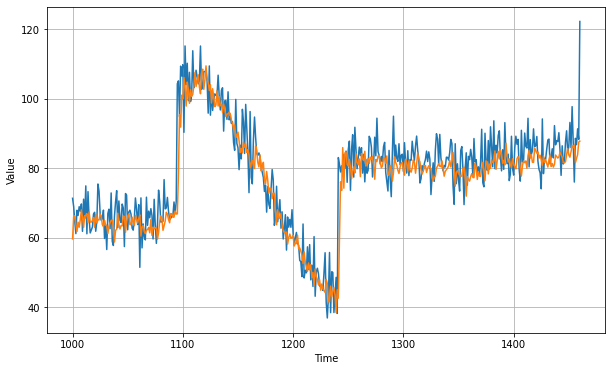

In [25]:
## squeeze the forecast results to plot

results = forecast.squeeze()

# plot
plot_series(valid_time, (valid_series, results))

In [26]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(valid_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy())

47.271866
5.042712


### using Learning Rate Schedular

In [37]:
# generate data
# changing window_size = 20
window_size = 20

train_datasets = generate_windowed_datasets(train_series, batch_size, buffer_size, window_size)

for data in train_datasets.take(1):
    print('Shape feature: {}'.format(data[0].shape))
    print('Label feature: {}'.format(data[1].shape))
    print('Type : {}'.format(type(data)))
    print('Length: {}'.format(len(data)))

Shape feature: (32, 20)
Label feature: (32,)
Type : <class 'tuple'>
Length: 2


In [59]:
model_lr = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(30, activation='relu', input_shape = [window_size]),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
    
])

model_lr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________


In [60]:
# learning rate schedular

tf.keras.backend.clear_session()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20))

# compile

model_lr.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                loss='mse',
                metrics=['mae'])

num_epochs = 80

# training
model_lr.fit(train_datasets, epochs=num_epochs, callbacks=[lr_schedule])

Epoch 1/80
31/31 [==============================] - 0s 2ms/step - loss: 4416.7144 - mae: 60.5971 - lr: 1.0000e-08
Epoch 2/80
31/31 [==============================] - 0s 1ms/step - loss: 2532.2139 - mae: 45.6448 - lr: 1.1220e-08
Epoch 3/80
31/31 [==============================] - 0s 2ms/step - loss: 1328.1475 - mae: 32.5502 - lr: 1.2589e-08
Epoch 4/80
31/31 [==============================] - 0s 1ms/step - loss: 667.8290 - mae: 22.3932 - lr: 1.4125e-08
Epoch 5/80
31/31 [==============================] - 0s 2ms/step - loss: 340.0487 - mae: 14.8182 - lr: 1.5849e-08
Epoch 6/80
31/31 [==============================] - 0s 1ms/step - loss: 193.9615 - mae: 10.0780 - lr: 1.7783e-08
Epoch 7/80
31/31 [==============================] - 0s 2ms/step - loss: 139.1522 - mae: 7.8487 - lr: 1.9953e-08
Epoch 8/80
31/31 [==============================] - 0s 1ms/step - loss: 121.5274 - mae: 7.1773 - lr: 2.2387e-08
Epoch 9/80
31/31 [==============================] - 0s 1ms/step - loss: 116.3848 - mae: 7.0889 

Epoch 74/80
31/31 [==============================] - 0s 2ms/step - loss: 60.5445 - mae: 5.9559 - lr: 4.4668e-05
Epoch 75/80
31/31 [==============================] - 0s 1ms/step - loss: 56.3327 - mae: 5.7528 - lr: 5.0119e-05
Epoch 76/80
31/31 [==============================] - 0s 1ms/step - loss: 47.5485 - mae: 5.1742 - lr: 5.6234e-05
Epoch 77/80
31/31 [==============================] - 0s 2ms/step - loss: 79.6812 - mae: 6.9586 - lr: 6.3096e-05
Epoch 78/80
31/31 [==============================] - 0s 1ms/step - loss: 1112.0521 - mae: 25.2325 - lr: 7.0795e-05
Epoch 79/80
31/31 [==============================] - 0s 1ms/step - loss: 2030.6521 - mae: 40.5086 - lr: 7.9433e-05
Epoch 80/80
31/31 [==============================] - 0s 1ms/step - loss: 1004.0109 - mae: 25.9861 - lr: 8.9125e-05


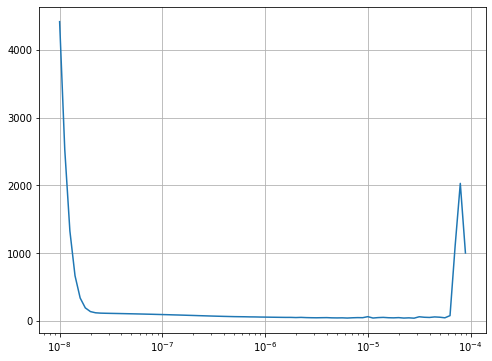

In [61]:
## plot lr against the loss
history = model_lr.history.history

#lrs = 1e-8 * (10 ** (np.arange(100) / 20))


plt.figure(figsize=(8,6))
plt.semilogx(history['lr'], history['loss'])
#plt.semilogx(lrs, history['loss'])
plt.grid(True)
plt.show();

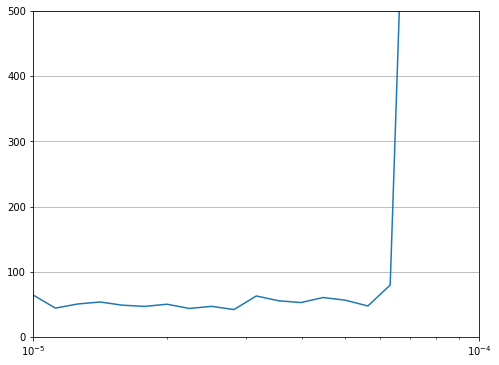

In [62]:
plt.figure(figsize=(8,6))
plt.semilogx(history['lr'], history['loss'])
#plt.semilogx(lrs, history['loss'])
plt.grid(True)
plt.axis([1e-5, 1e-4, 0, 500])
plt.show();

In [63]:
## REtune model
tf.keras.backend.clear_session()

model_lr_tune = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense(30, activation='relu', input_shape = [window_size]),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1)
    
])

learning_rate = 2e-5

model_lr_tune.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                loss='mse',
                metrics=['mae'])

# training
num_epochs = 200
model_lr_tune.fit(train_datasets, epochs=num_epochs)

Epoch 1/200
31/31 [==============================] - 0s 2ms/step - loss: 270.0797 - mae: 11.8251
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 58.7815 - mae: 5.5686
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 53.6889 - mae: 5.4321
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 59.4211 - mae: 5.7711
Epoch 5/200
31/31 [==============================] - 0s 1ms/step - loss: 47.4630 - mae: 5.0824
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 47.8544 - mae: 5.1883
Epoch 7/200
31/31 [==============================] - 0s 1ms/step - loss: 43.5152 - mae: 4.9060
Epoch 8/200
31/31 [==============================] - 0s 1ms/step - loss: 45.8966 - mae: 5.0745
Epoch 9/200
31/31 [==============================] - 0s 1ms/step - loss: 49.4705 - mae: 5.4133
Epoch 10/200
31/31 [==============================] - 0s 1ms/step - loss: 48.8173 - mae: 5.3348
Epoch 11/200
31/31 [===========================

31/31 [==============================] - 0s 1ms/step - loss: 43.1895 - mae: 4.9941
Epoch 87/200
31/31 [==============================] - 0s 1ms/step - loss: 38.9246 - mae: 4.7019
Epoch 88/200
31/31 [==============================] - 0s 1ms/step - loss: 36.0687 - mae: 4.4736
Epoch 89/200
31/31 [==============================] - 0s 2ms/step - loss: 38.8119 - mae: 4.6840
Epoch 90/200
31/31 [==============================] - 0s 1ms/step - loss: 36.0336 - mae: 4.5169
Epoch 91/200
31/31 [==============================] - 0s 1ms/step - loss: 36.9828 - mae: 4.6070
Epoch 92/200
31/31 [==============================] - 0s 1ms/step - loss: 32.2028 - mae: 4.1862
Epoch 93/200
31/31 [==============================] - 0s 1ms/step - loss: 33.4084 - mae: 4.3103
Epoch 94/200
31/31 [==============================] - 0s 1ms/step - loss: 36.6381 - mae: 4.5620
Epoch 95/200
31/31 [==============================] - 0s 1ms/step - loss: 35.2543 - mae: 4.4149
Epoch 96/200
31/31 [==============================] -

31/31 [==============================] - 0s 1ms/step - loss: 32.1558 - mae: 4.2491
Epoch 171/200
31/31 [==============================] - 0s 1ms/step - loss: 31.7625 - mae: 4.2445
Epoch 172/200
31/31 [==============================] - 0s 2ms/step - loss: 33.5989 - mae: 4.3842
Epoch 173/200
31/31 [==============================] - 0s 1ms/step - loss: 31.8556 - mae: 4.2475
Epoch 174/200
31/31 [==============================] - 0s 1ms/step - loss: 32.6827 - mae: 4.2720
Epoch 175/200
31/31 [==============================] - 0s 1ms/step - loss: 36.9437 - mae: 4.6582
Epoch 176/200
31/31 [==============================] - 0s 1ms/step - loss: 31.0145 - mae: 4.1409
Epoch 177/200
31/31 [==============================] - 0s 1ms/step - loss: 31.2720 - mae: 4.1582
Epoch 178/200
31/31 [==============================] - 0s 1ms/step - loss: 30.5144 - mae: 4.1476
Epoch 179/200
31/31 [==============================] - 0s 1ms/step - loss: 31.5287 - mae: 4.2096
Epoch 180/200
31/31 [=======================

In [50]:
# plot function

# plot loss and accuracy values 
def plot_metrics(df, num_epochs):
	
	epoch_range = range(num_epochs)
	plt.figure(figsize=(8,6))
	plt.plot(epoch_range, df['loss'], label = 'training_loss')
# 	plt.plot(epoch_range, df['val_loss'], label = 'validation_loss')
# 	plt.plot(epoch_range, df['accuracy'], label = 'training_accuracy')
# 	plt.plot(epoch_range, df['val_accuracy'], label = 'validation_accuracy')
	plt.legend(loc='best')
	plt.show()

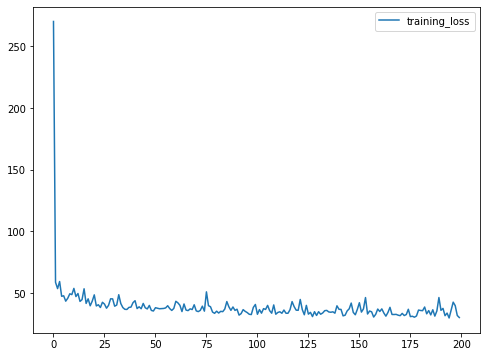

In [64]:
metrics = pd.DataFrame(model_lr_tune.history.history)
plot_metrics(metrics, num_epochs)

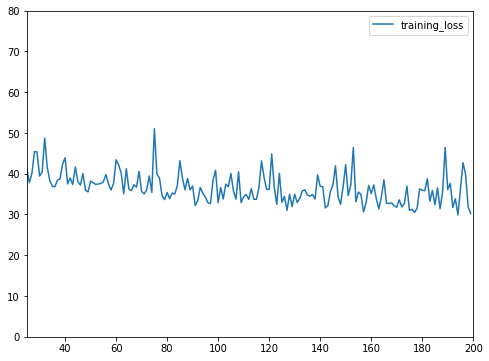

In [67]:
epoch_range = range(num_epochs)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'], label = 'training_loss')
# 	plt.plot(epoch_range, df['val_loss'], label = 'validation_loss')
# 	plt.plot(epoch_range, df['accuracy'], label = 'training_accuracy')
# 	plt.plot(epoch_range, df['val_accuracy'], label = 'validation_accuracy')
plt.axis([25, 200, 0,80])
plt.legend(loc='best')
plt.show()

In [68]:
## predictions for all validation data

forecast = []

# forecast data 
forecast_data = series[split_time - window_size:]

for i in range(len(forecast_data) - window_size):
    forecast.append(model_lr_tune.predict(np.expand_dims(forecast_data[i:i+window_size], 0)))
    
# convert into numpy array
forecast = np.array(forecast)
print(forecast.shape)
## squeeze the forecast results to plot

results = forecast.squeeze()

# # plot
# plot_series(valid_time, (valid_series, results))

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 16ms/step
(461, 1, 1)


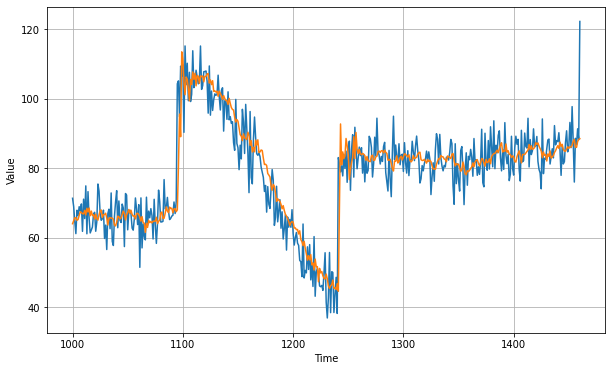

In [69]:
# plot
plot_series(valid_time, (valid_series, results))

In [47]:
# Compute the metrics
# when epochs = 100
print(tf.keras.metrics.mean_squared_error(valid_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy())

43.05841
4.92719


In [70]:
# Compute the metrics
# when epochs = 200 and Dense layers has 30 units
print(tf.keras.metrics.mean_squared_error(valid_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy())

41.298534
4.722964


### saving model and re-loading to predict

In [71]:
# Save your model in HDF5 format
model_lr_tune.save('model_rl_tune.h5')

In [73]:
# load model and use for prediction again

reload_model = tf.keras.models.load_model('model_rl_tune.h5')
reload_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                630       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,591
Trainable params: 1,591
Non-trainable params: 0
_________________________________________________________________


In [74]:
## prediction on single window data

# prediction using just one batch
print(series[:window_size].shape)

print(np.expand_dims(series[:window_size], 0).shape)

print(reload_model.predict(np.expand_dims(series[:window_size], 0)))

(20,)
(1, 20)
1/1 [==============================] - 0s 52ms/step
[[46.15864]]


## using Simple RNN layers
- use Lambda layers to reshape our inputs data to 3d shape : our intial input shape was (32, 30) - (batch_size, timesteps)
- now, needs to be converted to (32, 20, 1) to feed into RNN
- Also, need to scale the output to the original scale as the tanh activaion function in the SimpleRNN will convert the outputs to [-1, 1] scales

In [88]:
model_RNN = tf.keras.models.Sequential([
    
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1), input_shape = [window_size]),
    
    tf.keras.layers.SimpleRNN(32, activation='relu', return_sequences = True),
    tf.keras.layers.SimpleRNN(32, activation='relu'),
    tf.keras.layers.Dense(1),
                                                                    
    # to rescale output values
    tf.keras.layers.Lambda(lambda x: x* 100)
])

model_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_6 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 20, 32)            1088      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
 lambda_7 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [89]:
# learning rate schedular

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20))

# compile

model_RNN.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                loss=tf.keras.losses.Huber(),
                metrics=['mae'])

num_epochs = 100

# training
model_RNN.fit(train_datasets, epochs=num_epochs, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 714.6263 - mae: 715.1263 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 401.7371 - mae: 402.2370 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 162.6640 - mae: 163.1628 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 117.4777 - mae: 117.9768 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 105.2820 - mae: 105.7808 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 96.9748 - mae: 97.4741 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 88.5040 - mae: 89.0022 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 78.9353 - mae: 79.4339 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 70.2162 - mae

31/31 [==============================] - 0s 6ms/step - loss: 5.7666 - mae: 6.2498 - lr: 3.9811e-05
Epoch 74/100
31/31 [==============================] - 0s 7ms/step - loss: 6.1380 - mae: 6.6213 - lr: 4.4668e-05
Epoch 75/100
31/31 [==============================] - 0s 6ms/step - loss: 6.5500 - mae: 7.0325 - lr: 5.0119e-05
Epoch 76/100
31/31 [==============================] - 0s 7ms/step - loss: 7.0635 - mae: 7.5478 - lr: 5.6234e-05
Epoch 77/100
31/31 [==============================] - 0s 6ms/step - loss: 6.5836 - mae: 7.0663 - lr: 6.3096e-05
Epoch 78/100
31/31 [==============================] - 0s 7ms/step - loss: 6.3454 - mae: 6.8256 - lr: 7.0795e-05
Epoch 79/100
31/31 [==============================] - 0s 6ms/step - loss: 5.5080 - mae: 5.9891 - lr: 7.9433e-05
Epoch 80/100
31/31 [==============================] - 0s 6ms/step - loss: 6.4613 - mae: 6.9415 - lr: 8.9125e-05
Epoch 81/100
31/31 [==============================] - 0s 6ms/step - loss: 7.7071 - mae: 8.1942 - lr: 1.0000e-04
Epoch

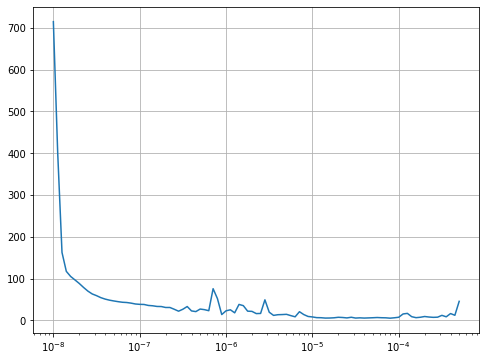

In [90]:
## plot lr against the loss
history = model_RNN.history.history

#lrs = 1e-8 * (10 ** (np.arange(100) / 20))


plt.figure(figsize=(8,6))
plt.semilogx(history['lr'], history['loss'])
#plt.semilogx(lrs, history['loss'])
plt.grid(True)
plt.show();

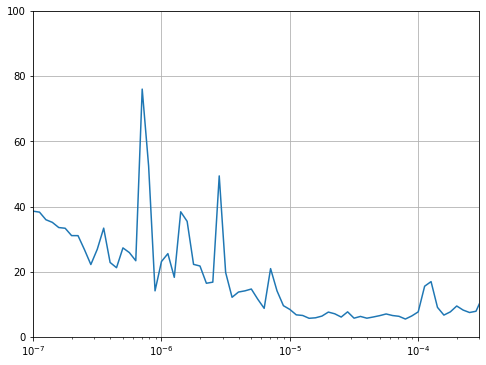

In [91]:
plt.figure(figsize=(8,6))
plt.semilogx(history['lr'], history['loss'])
#plt.semilogx(lrs, history['loss'])
plt.grid(True)
plt.axis([1e-7, 3e-4, 0, 100])
plt.show();

In [97]:
model_RNN_tune = tf.keras.models.Sequential([
    
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, -1), input_shape = [window_size]),
    
    tf.keras.layers.SimpleRNN(32, activation='relu', return_sequences = True),
    tf.keras.layers.SimpleRNN(32, activation='relu'),
    tf.keras.layers.Dense(1),
                                                                    
    # to rescale output values
    tf.keras.layers.Lambda(lambda x: x* 100)
])

model_RNN_tune.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_12 (Lambda)          (None, 20, 1)             0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 20, 32)            1088      
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
 lambda_13 (Lambda)          (None, 1)                 0         
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [98]:
# compile
learning_rate = 1e-5

model_RNN_tune.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
                loss=tf.keras.losses.Huber(),
                metrics=['mae'])

num_epochs = 200

# training
model_RNN_tune.fit(train_datasets, epochs=num_epochs)

Epoch 1/200
31/31 [==============================] - 2s 7ms/step - loss: 194.1958 - mae: 194.6937
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 12.6991 - mae: 13.1846
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 7.3176 - mae: 7.7935
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 8.1066 - mae: 8.5952
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 7.1432 - mae: 7.6248
Epoch 6/200
31/31 [==============================] - 0s 7ms/step - loss: 5.7766 - mae: 6.2599
Epoch 7/200
31/31 [==============================] - 0s 6ms/step - loss: 5.5567 - mae: 6.0373
Epoch 8/200
31/31 [==============================] - 0s 7ms/step - loss: 5.5342 - mae: 6.0150
Epoch 9/200
31/31 [==============================] - 0s 7ms/step - loss: 5.7913 - mae: 6.2728
Epoch 10/200
31/31 [==============================] - 0s 6ms/step - loss: 6.4246 - mae: 6.9038
Epoch 11/200
31/31 [==============================] -

31/31 [==============================] - 0s 7ms/step - loss: 4.6930 - mae: 5.1729
Epoch 88/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3779 - mae: 4.8536
Epoch 89/200
31/31 [==============================] - 0s 6ms/step - loss: 4.6743 - mae: 5.1516
Epoch 90/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4018 - mae: 4.8780
Epoch 91/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3163 - mae: 4.7945
Epoch 92/200
31/31 [==============================] - 0s 6ms/step - loss: 4.5213 - mae: 5.0016
Epoch 93/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3700 - mae: 4.8443
Epoch 94/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4086 - mae: 4.8859
Epoch 95/200
31/31 [==============================] - 0s 6ms/step - loss: 4.5695 - mae: 5.0496
Epoch 96/200
31/31 [==============================] - 0s 7ms/step - loss: 4.5691 - mae: 5.0489
Epoch 97/200
31/31 [==============================] - 0s 7ms/st

31/31 [==============================] - 0s 6ms/step - loss: 4.4739 - mae: 4.9537
Epoch 173/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3716 - mae: 4.8475
Epoch 174/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3511 - mae: 4.8268
Epoch 175/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4777 - mae: 4.9576
Epoch 176/200
31/31 [==============================] - 0s 7ms/step - loss: 4.4643 - mae: 4.9430
Epoch 177/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4452 - mae: 4.9174
Epoch 178/200
31/31 [==============================] - 0s 6ms/step - loss: 4.7065 - mae: 5.1855
Epoch 179/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4801 - mae: 4.9556
Epoch 180/200
31/31 [==============================] - 0s 6ms/step - loss: 4.3445 - mae: 4.8217
Epoch 181/200
31/31 [==============================] - 0s 6ms/step - loss: 4.4661 - mae: 4.9383
Epoch 182/200
31/31 [==============================] -

In [99]:
## predictions for all validation data

forecast = []

# forecast data 
forecast_data = series[split_time - window_size:]

for i in range(len(forecast_data) - window_size):
    forecast.append(model_RNN_tune.predict(np.expand_dims(forecast_data[i:i+window_size], 0)))
    
# convert into numpy array
forecast = np.array(forecast)
print(forecast.shape)
## squeeze the forecast results to plot

results = forecast.squeeze()

# # plot
# plot_series(valid_time, (valid_series, results))

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
(461, 1, 1)


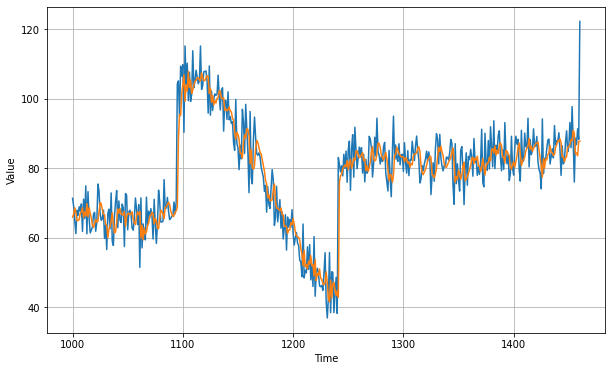

In [100]:
# plot
plot_series(valid_time, (valid_series, results))

In [101]:
# Compute the metrics
# when epochs = 200 and Dense layers has 30 units
print(tf.keras.metrics.mean_squared_error(valid_series, results).numpy())
print(tf.keras.metrics.mean_absolute_error(valid_series, results).numpy())

41.53866
4.723722


### Predict using sample data

In [112]:
sample_test = series[:window_size]
print(sample_test.shape)

# reshape
sample_test = np.expand_dims(sample_test,0)
print(sample_test.shape)

# the input shape will be taken care by the model
model_RNN_tune.predict(sample_test)

(20,)
(1, 20)
1/1 [==============================] - 0s 19ms/step


array([[44.760834]], dtype=float32)